Loading Data

In [1]:
%pip install panda
%pip install numpy
%pip install matplotlib 
%pip install squalchemy 
%pip install psycopg2
%pip install sklearn
%pip install xgboost
%pip install joblib
import pandas as pd # type: ignore
import numpy as np # type: ignore
from matplotlib import pyplot as plt # type: ignore
from sqlalchemy import create_engine # type: ignore
import psycopg2 # type: ignore
from sklearn.ensemble import IsolationForest # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import mean_squared_error # type: ignore
from sklearn.model_selection import GridSearchCV # type: ignore
from sklearn.model_selection import cross_val_score # type: ignore
import xgboost as xgb # type: ignore
import sklearn # type: ignore
import joblib #type: ignore
print(sklearn.__version__)



ModuleNotFoundError: No module named 'pandas'

In [43]:
# Connecting to Postgres server

# Define Connection Parameters
conn_params = {
    "host":"10.231.32.104",
    "port":"5432",
    "dbname":"cov_density",
    "user":"webuser",
    "password":"webuser"
}

# Connect to PostgreSQL
conn = psycopg2.connect(**conn_params)
print("Connection successful!")

# Querying table for info
query = "SELECT date, hour, building_floor, density_cnt, densitymap_hourly.building_name FROM public.densitymap_hourly WHERE building_desc = '915 COMMONWEALTH AVENUE'AND hour >= 6 AND hour <=23 AND date >= '2024-09-03' ORDER BY date ASC;"
df = pd.read_sql(query, conn)
df


Connection successful!


C:\Users\dripp\AppData\Local\Temp\ipykernel_28840\3214425936.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,date,hour,building_floor,density_cnt,building_name
0,2024-09-03,6,1,57,FITNESS AND RECREATION CENTER
1,2024-09-03,6,2,12,FITNESS AND RECREATION CENTER
2,2024-09-03,8,l,8,FITNESS AND RECREATION CENTER
3,2024-09-03,13,1,128,FITNESS AND RECREATION CENTER
4,2024-09-03,15,1,157,FITNESS AND RECREATION CENTER
...,...,...,...,...,...
7943,2025-01-08,14,3,13,FITNESS AND RECREATION CENTER
7944,2025-01-08,16,l,19,FITNESS AND RECREATION CENTER
7945,2025-01-08,18,1,88,FITNESS AND RECREATION CENTER
7946,2025-01-08,18,2,29,FITNESS AND RECREATION CENTER


EDA

In [45]:
# Checking for data types
data_types = df.dtypes

# Checking for missing values
missing_vals = {col:df[col].isna().sum() for col in df.columns}

# Checking for entries that don't make sense
illogical_vals = df[(df['hour']==0) | (df['density_cnt']<0)]

print(data_types, missing_vals, illogical_vals)

date              object
hour               int64
building_floor    object
density_cnt        int64
building_name     object
dtype: object {'date': 0, 'hour': 0, 'building_floor': 0, 'density_cnt': 0, 'building_name': 0} Empty DataFrame
Columns: [date, hour, building_floor, density_cnt, building_name]
Index: []


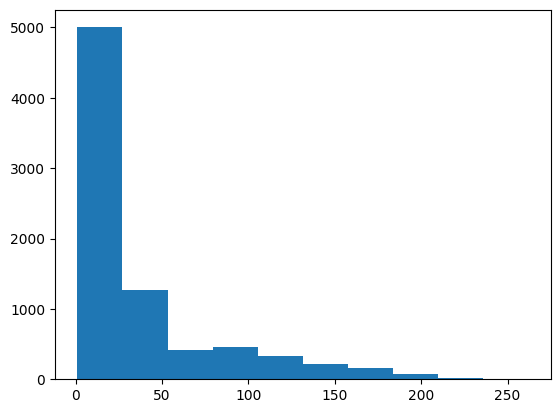

In [46]:
# Checking for outliers in the density count with a histogram
plt.hist(df['density_cnt'])
plt.show()

Preprocessing Data and Feature Engineering

In [47]:
# Using One Hot Encoding to use the buidling_floor feature in ML models
df_mod = pd.get_dummies(df, columns=['building_floor'], drop_first=True, dtype=int)

# Adding back the original buidling floor column for consistency 
df_mod['building_floor'] = df['building_floor']


# Adding a real time hour feature to use for ML modeling
df_mod['real_time_hour'] = df_mod['hour'] + 1

df_mod

,date,hour,density_cnt,building_name,building_floor_2,building_floor_3,building_floor_l,buidling_floor,real_time_hour
0,2024-09-03,6,57,FITNESS AND RECREATION CENTER,0,0,0,1,7
1,2024-09-03,6,12,FITNESS AND RECREATION CENTER,1,0,0,2,7
2,2024-09-03,8,8,FITNESS AND RECREATION CENTER,0,0,1,l,9
3,2024-09-03,13,128,FITNESS AND RECREATION CENTER,0,0,0,1,14
4,2024-09-03,15,157,FITNESS AND RECREATION CENTER,0,0,0,1,16
...,...,...,...,...,...,...,...,...,...
7943,2025-01-08,14,13,FITNESS AND RECREATION CENTER,0,1,0,3,15
7944,2025-01-08,16,19,FITNESS AND RECREATION CENTER,0,0,1,l,17
7945,2025-01-08,18,88,FITNESS AND RECREATION CENTER,0,0,0,1,19
7946,2025-01-08,18,29,FITNESS AND RECREATION CENTER,1,0,0,2,19


In [48]:
# Identifying outliers statistically - Using IQR 
Q1 = df_mod['density_cnt'].quantile(0.25)
Q3 = df_mod['density_cnt'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)

# Subsetting the dataframe to exclude all outliers identified with the IQR method
IQR_df = df_mod[(df_mod['density_cnt'] >= lower_bound) & (df_mod['density_cnt'] <= upper_bound)]
IQR_df

,date,hour,density_cnt,building_name,building_floor_2,building_floor_3,building_floor_l,buidling_floor,real_time_hour
0,2024-09-03,6,57,FITNESS AND RECREATION CENTER,0,0,0,1,7
1,2024-09-03,6,12,FITNESS AND RECREATION CENTER,1,0,0,2,7
2,2024-09-03,8,8,FITNESS AND RECREATION CENTER,0,0,1,l,9
5,2024-09-03,15,33,FITNESS AND RECREATION CENTER,1,0,0,2,16
6,2024-09-03,6,8,FITNESS AND RECREATION CENTER,0,0,1,l,7
...,...,...,...,...,...,...,...,...,...
7943,2025-01-08,14,13,FITNESS AND RECREATION CENTER,0,1,0,3,15
7944,2025-01-08,16,19,FITNESS AND RECREATION CENTER,0,0,1,l,17
7945,2025-01-08,18,88,FITNESS AND RECREATION CENTER,0,0,0,1,19
7946,2025-01-08,18,29,FITNESS AND RECREATION CENTER,1,0,0,2,19


In [49]:
# Identifying outliers with ML - Using Isolation Forest

# 5% as the contamination amount
iso = IsolationForest(contamination=0.05, random_state=42)
df_mod['anomaly'] = iso.fit_predict(df_mod[['hour', 'density_cnt', 'building_floor_2', 'building_floor_3', 'building_floor_l']])

# Subsetting the dataframe to exclude all outliers identified with the Isolation Forest method
iso_df = df_mod[df_mod['anomaly'] == 1]
iso_df


,date,hour,density_cnt,building_name,building_floor_2,building_floor_3,building_floor_l,buidling_floor,real_time_hour,anomaly
0,2024-09-03,6,57,FITNESS AND RECREATION CENTER,0,0,0,1,7,1
2,2024-09-03,8,8,FITNESS AND RECREATION CENTER,0,0,1,l,9,1
3,2024-09-03,13,128,FITNESS AND RECREATION CENTER,0,0,0,1,14,1
4,2024-09-03,15,157,FITNESS AND RECREATION CENTER,0,0,0,1,16,1
5,2024-09-03,15,33,FITNESS AND RECREATION CENTER,1,0,0,2,16,1
...,...,...,...,...,...,...,...,...,...,...
7943,2025-01-08,14,13,FITNESS AND RECREATION CENTER,0,1,0,3,15,1
7944,2025-01-08,16,19,FITNESS AND RECREATION CENTER,0,0,1,l,17,1
7945,2025-01-08,18,88,FITNESS AND RECREATION CENTER,0,0,0,1,19,1
7946,2025-01-08,18,29,FITNESS AND RECREATION CENTER,1,0,0,2,19,1


Predictions with XGBoost

In [ ]:
# Tuning Hyper Parameters and Cross Validating with GridSearch

# Creating a list of the dfs
dfs = [df_mod, IQR_df, iso_df]
comparisons = {}

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}

def run_grid_search(df):

    # Initializing X and Y variables
    X = df[['hour', 'building_floor_2', 'building_floor_3', 'building_floor_l']]
    Y = df['density_cnt']

    # Splitting into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Initialize model
    xgb_model = xgb.XGBRegressor(random_state=42)

    # Perform Grid Search - CV argument handles cross validation
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
    grid_search.fit(X_train, y_train)

    # Best Model and Score for the dataframe
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_

    return [best_score, best_model, X_test, y_test]

for i, df in enumerate(dfs):
    comparisons[run_grid_search(df)[0]] = [i, run_grid_search(df)[1], run_grid_search(df)[2], run_grid_search(df)[3]]

# Using max because the scoring is the negative mean squared error
best_df = dfs[comparisons[max(comparisons)][0]]
best_model = comparisons[max(comparisons)][1]

# Best Dataframe: IQR_df
joblib.dump(best_model, 'xgboost_model.pkl')
print("Model saved as xgboost_model.pkl")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [24]:
# Implementing Best Model and Best Dataframe
X_test = comparisons[max(comparisons)][2]
y_test = comparisons[max(comparisons)][3]
y_pred = best_model.predict(X_test)

# Evaluating Model Accuracy
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse)

# Rmse = 14.707253678870051
# An RMSE of 14 is around 16% of the range (14 / 88)
# Meaning the model's error is relatively small compared to the range of values it is predicting
# On a 1-10 scale, the model's probably at a 7

14.707253678870051


In [1]:
# Using model to predict the real time density counts


X_vars = IQR_df[['real_time_hour', 'building_floor_2', 'building_floor_3', 'building_floor_l']]
IQR_df['real_time_density_cnt'] = best_model.predict(X_vars)
IQR_df




ModuleNotFoundError: No module named 'joblib'